# Imports

In [2]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [6]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if project_config['chain_notebooks'] == '1':

  !pip install papermill
  !pip install nbconvert
  !pip install nbformat
  !pip install IPython

  import papermill as pm
  import nbformat
  from nbconvert import HTMLExporter
  from IPython.display import HTML, display

  input_file = f"{os.getenv('PROJECT_PATH')}{project_config['notebooks_directory']}{project_config['notebook1']}"
  output_file = f"{os.getenv('PROJECT_PATH')}{project_config['output_directory']}{project_config['output1']}"

  # --- Execute the proviuse notebook with parameters ---
  pm.execute_notebook(
      input_path = input_file,
      output_path = output_file,
      log_output=False,  # don't print logs while running
      progress_bar=True
  )

  # --- Convert the executed notebook to HTML ---
  nb = nbformat.read(output_file, as_version=4)
  html_exporter = HTMLExporter()
  html_exporter.template_name = "lab"  # modern look; alternatives: 'classic', 'basic'
  body, _ = html_exporter.from_notebook_node(nb)

  # --- Display the HTML result inline ---
  display(HTML(body))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00


Executing:   0%|          | 0/25 [00:00<?, ?cell/s]

# Load dataset file of current TKL

In [3]:
print(f"Loading dataset for {project_config['TKL']} .....\n")

DATASET = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
df_all = pd.read_csv(DATASET, index_col=False)
df_all = df_all.drop(columns=["Unnamed: 0"])

cols_orig = [col for col in df_all.columns if col.endswith('_orig')]
cols_normalized = [col for col in df_all.columns if not col.endswith('_orig')]

df = df_all[cols_normalized]
df_orig = df_all[['Date'] + cols_orig]

print(f"\ndf for training")
print(f"-----------------")
display(df.tail(1))

print(f"\ndf for visualization")
print(f"----------------------")
display(df_orig.tail(1))

Loading dataset for ATCMF .....


df for training
-----------------


,Date,y_next,NASDAQ_max_10,y_std_65,y_lag_2,y_mean_5,NASDAQ,y_diff_65,y_min_5,y,y_diff_10,y_std_5,y_max_5,SP500_max_5,y_diff_22,y_diff_5,Oil
4821,2025-12-05,0.139535,0.983237,0.022781,0.142706,0.142706,0.983237,0.05814,0.140592,0.141649,0.020085,0.002479,0.146934,0.996703,0.04334,0.009514,0.534168



df for visualization
----------------------


,Date,NASDAQ_max_10_orig,y_std_65_orig,y_lag_2_orig,y_mean_5_orig,NASDAQ_orig,y_diff_65_orig,y_min_5_orig,y_orig,y_diff_10_orig,y_std_5_orig,y_max_5_orig,SP500_max_5_orig,y_diff_22_orig,y_diff_5_orig,Oil_orig,y_next_orig
4821,2025-12-05,23578.130859,0.021551,0.16,0.16,23578.130859,0.055,0.158,0.159,0.019,0.002345,0.164,6870.399902,0.041,0.009,60.080002,0.157


# Data prep

In [4]:
def make_datasets(df, X_cols, y_col):

    LOOK_BACK_DAYS = int(project_config['LOOK_BACK_DAYS'])

    X, y = [], []

    for i in range(LOOK_BACK_DAYS, len(df)):
        X.append(df.loc[i-LOOK_BACK_DAYS:i-1, X_cols].values)
        y.append(df.loc[i, y_col].values[0])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    split = int(0.9 * len(X))

    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    dates = pd.to_datetime(df['Date'])
    dates_test = dates[-len(y_test):].values

    return X_train, X_test, y_train, y_test, dates_test

In [5]:
def train_predict(X_train, X_test, y_train, y_test, features, model_name, epochs=0, batch_size=0):

  from tensorflow.keras.models import Sequential, Model
  from tensorflow.keras.layers import LSTM, Dense, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Concatenate

  epochs = int(project_config['TRAIN_EPOCS']) if epochs == 0 else epochs
  batch_size = int(project_config['TRAIN_BATCH_SIZE']) if batch_size == 0 else batch_size

  if model_name == 'Parallel.LSTM.GRU':
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))
    lstm_branch = LSTM(units=50, return_sequences=False)(input_layer)
    gru_branch = GRU(units=50, return_sequences=False)(input_layer)
    merged = Concatenate()([lstm_branch, gru_branch])
    dropout = Dropout(0.1, name='dropout_layer')(merged)
    output_layer = Dense(1, activation='sigmoid')(dropout)
    model = Model(inputs=input_layer, outputs=output_layer)

  if model_name == 'Cascase.CNN.GRU':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        GRU(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
  ])

  if model_name == 'Cascase.CNN.LSTM':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
  ])

  if model_name == 'CNN':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(1)
  ])

  if model_name == 'LSTM':
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
        LSTM(10),
        Dense(1)
  ])

  if model_name == 'GRU':
    model = Sequential([
      GRU(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
      GRU(10),
      Dense(1)
  ])

  model.compile(optimizer='adam', loss='mse')

  print("=====================================================================")
  print(f"Model: {model_name}")
  print(f"Neatures: {features}")
  model.summary()

  #history = model.fit(X_train, y_train,
  history = model.fit(X_train, y_train,
                      epochs=int(project_config['TRAIN_EPOCS']),
                      batch_size=int(project_config['TRAIN_BATCH_SIZE']),
                      validation_data=(X_test, y_test),
                      verbose=1)

  pred = model.predict(X_test)

  # Calculate min and max for 'y_next' from the original unscaled data (df_orig)
  # This allows us to manually inverse transform the single predicted value.
  min_y_next_orig = df_orig['y_next_orig'].min()
  max_y_next_orig = df_orig['y_next_orig'].max()

  # Inverse transform the scaled prediction using the min-max formula
  unscaled_prediction = pred * (max_y_next_orig - min_y_next_orig) + min_y_next_orig
  unscaled_y_test = y_test * (max_y_next_orig - min_y_next_orig) + min_y_next_orig

  from sklearn.metrics import mean_absolute_error
  mae = mean_absolute_error(unscaled_y_test, unscaled_prediction)
  print(f"MAE: {mae:.4f}")

  from sklearn.metrics import r2_score
  r2 = r2_score(unscaled_y_test, unscaled_prediction)
  print(f"R²: {r2:.4f}")

  return unscaled_prediction, unscaled_y_test, model

In [6]:
X_cols_full = [col for col in df.columns if col not in ['Date','y_next']]
X_cols_exho = [col for col in df.columns if '_' not in col and col != 'Date']
X_cols_tkl  = ['y']
y_col       = ['y_next']

# **Racing Models:**
# LSTM, GRU, CNN, Cascade CNN LSTM, Cascade CNN GRU, Parallel LSTM GRU

In [7]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

results_df = pd.DataFrame(columns=[ "model_name", "X_cols",  "prediction", "mae", "r2", "model" ])

for X_cols in [X_cols_full, X_cols_exho, X_cols_tkl]:

  X_train, X_test, y_train, y_test, dates_test = make_datasets(df, X_cols, y_col)

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Parallel.LSTM.GRU")
  results_df.loc[len(results_df)] = {
    "model_name": "Parallel.LSTM.GRU",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
    }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Cascase.CNN.GRU")
  results_df.loc[len(results_df)] = {
    "model_name": "Cascase.CNN.GRU",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
    }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Cascase.CNN.LSTM")
  results_df.loc[len(results_df)] = {
    "model_name": "Cascase.CNN.LSTM",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
    }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="CNN")
  results_df.loc[len(results_df)] = {
    "model_name": "CNN",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
    }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="GRU")
  results_df.loc[len(results_df)] = {
    "model_name": "GRU",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
  }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="LSTM")
  results_df.loc[len(results_df)] = {
    "model_name": "LSTM",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
  }

Model: Parallel.LSTM.GRU
Neatures: ['NASDAQ_max_10', 'y_std_65', 'y_lag_2', 'y_mean_5', 'NASDAQ', 'y_diff_65', 'y_min_5', 'y', 'y_diff_10', 'y_std_5', 'y_max_5', 'SP500_max_5', 'y_diff_22', 'y_diff_5', 'Oil']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 66, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50)        │     13,200 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 50)        │     10,050 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 100)       │          0 │ concatenate[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        101 │ dropout_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,351 (91.21 KB)

 Trainable params: 23,351 (91.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.0242 - val_loss: 0.0018
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0012 - val_loss: 5.2010e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 9.7811e-04 - val_loss: 5.4379e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 7.7448e-04 - val_loss: 7.3046e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 7.0517e-04 - val_loss: 8.1169e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 6.3823e-04 - val_loss: 3.6034e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 6.5042e-04 - val_loss: 3.0751e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 6.4547e-04 - val_loss: 5.4678e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 6.7169e-04 - val_loss: 4.1584e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 5.8804e-04 - val_loss: 8.4576e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - lo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 64)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,645 (84.55 KB)

 Trainable params: 21,645 (84.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0247 - val_loss: 0.0021
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7.3705e-04 - val_loss: 6.6391e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 6.3011e-04 - val_loss: 0.0019
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 4.9040e-04 - val_loss: 6.9279e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.9609e-04 - val_loss: 5.7281e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.4729e-04 - val_loss: 4.3112e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 5.0920e-04 - val_loss: 5.0949e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 4.7273e-04 - val_loss: 4.0109e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 6.4234e-04 - val_loss: 5.4499e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.9273e-04 - val_loss: 3.3261e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,245 (106.43 KB)

 Trainable params: 27,245 (106.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0412 - val_loss: 0.0032
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 7.6301e-04 - val_loss: 0.0012
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 6.6136e-04 - val_loss: 0.0021
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.3970e-04 - val_loss: 0.0019
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 5.7080e-04 - val_loss: 0.0011
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 5.5140e-04 - val_loss: 9.6474e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.8554e-04 - val_loss: 0.0010
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 5.6785e-04 - val_loss: 0.0012
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 6.2603e-04 - val_loss: 0.0013
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.0768e-04 - val_loss: 7.8725e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.4947e-04 - val_loss: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 64, 64)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │       192,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,849 (858.79 KB)

 Trainable params: 219,849 (858.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0307 - val_loss: 7.6788e-04
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0051 - val_loss: 4.9464e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0047 - val_loss: 4.5507e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0049 - val_loss: 7.9739e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0047 - val_loss: 7.6743e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0041 - val_loss: 9.7445e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0032 - val_loss: 8.9904e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0032 - val_loss: 8.1277e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0030 - val_loss: 8.5845e-04
Epoch

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 66, 50)         │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,921 (46.57 KB)

 Trainable params: 11,921 (46.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.1633 - val_loss: 0.0014
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0015 - val_loss: 4.1041e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 9.1067e-04 - val_loss: 2.0049e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 6.8487e-04 - val_loss: 1.6187e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 5.4322e-04 - val_loss: 1.5833e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 4.9645e-04 - val_loss: 2.8680e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 4.9231e-04 - val_loss: 2.9155e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 4.3971e-04 - val_loss: 1.8633e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 4.2616e-04 - val_loss: 2.3241e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 4.4568e-04 - val_loss: 2.2967e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/st

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 66, 50)         │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,651 (61.14 KB)

 Trainable params: 15,651 (61.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0159 - val_loss: 0.0011
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 7.6586e-04 - val_loss: 5.4056e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 7.7033e-04 - val_loss: 6.1216e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 7.6464e-04 - val_loss: 2.9677e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 6.9725e-04 - val_loss: 5.8644e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 6.2938e-04 - val_loss: 1.8560e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 6.3931e-04 - val_loss: 1.9516e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 5.6940e-04 - val_loss: 2.1319e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 5.9819e-04 - val_loss: 1.9925e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 5.4029e-04 - val_loss: 2.0262e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step 

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 66, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 50)        │     10,800 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 50)        │      8,250 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ lstm_4[0][0],     │
│ (Concatenate)       │                   │            │ gru_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 100)       │          0 │ concatenate_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        101 │ dropout_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,151 (74.81 KB)

 Trainable params: 19,151 (74.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 0.0427 - val_loss: 9.1055e-04
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 9.8860e-04 - val_loss: 0.0014
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 9.2367e-04 - val_loss: 5.7956e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 7.9051e-04 - val_loss: 0.0012
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 8.6189e-04 - val_loss: 3.4960e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 8.5090e-04 - val_loss: 0.0019
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 8.4732e-04 - val_loss: 5.1044e-04

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 64, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,341 (75.55 KB)

 Trainable params: 19,341 (75.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0473 - val_loss: 3.8506e-04
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 6.6189e-04 - val_loss: 2.5657e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 7.0319e-04 - val_loss: 4.3618e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 6.4903e-04 - val_loss: 2.3147e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7.0096e-04 - val_loss: 2.2080e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.0824e-04 - val_loss: 2.4642e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 6.3866e-04 - val_loss: 2.2361e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.1087e-04 - val_loss: 2.6439e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 5.6368e-04 - val_loss: 2.6317e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 5.6220e-04 - val_loss: 2.7177e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 64, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,941 (97.43 KB)

 Trainable params: 24,941 (97.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0425 - val_loss: 4.5938e-04
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0012 - val_loss: 6.2268e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0012 - val_loss: 3.3107e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 9.4649e-04 - val_loss: 3.2439e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 7.9687e-04 - val_loss: 2.9039e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 7.6750e-04 - val_loss: 3.1993e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.8339e-04 - val_loss: 2.7599e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 7.3419e-04 - val_loss: 3.2422e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7.2313e-04 - val_loss: 3.4669e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 7.1712e-04 - val_loss: 2.9571e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss:

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 64, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │       192,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,545 (849.79 KB)

 Trainable params: 217,545 (849.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0449 - val_loss: 0.0024
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0065 - val_loss: 7.7950e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0056 - val_loss: 8.8138e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0053 - val_loss: 0.0011
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0050 - val_loss: 6.8578e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0046 - val_loss: 9.1830e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0042 - val_loss: 0.0010
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 12/20
134/134 ━━━━━

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 66, 50)         │         8,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,121 (39.54 KB)

 Trainable params: 10,121 (39.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - loss: 0.1522 - val_loss: 0.0061
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - loss: 0.0011 - val_loss: 5.0910e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 5.8420e-04 - val_loss: 1.6610e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 5.8426e-04 - val_loss: 2.0173e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 5.2409e-04 - val_loss: 1.7976e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 4.4613e-04 - val_loss: 1.4570e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 4.6926e-04 - val_loss: 1.3731e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 4.9395e-04 - val_loss: 1.5674e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 4.8198e-04 - val_loss: 1.6723e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 5.0676e-04 - val_loss: 1.5643e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/st

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 66, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,251 (51.76 KB)

 Trainable params: 13,251 (51.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0482 - val_loss: 0.0010
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0011 - val_loss: 8.6857e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 8.6403e-04 - val_loss: 0.0013
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 7.9180e-04 - val_loss: 0.0010
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 9.1927e-04 - val_loss: 0.0014
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 8.4509e-04 - val_loss: 0.0015
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 7.9333e-04 - val_loss: 0.0014
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 8.2330e-04 - val_loss: 0.0011
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 8.3979e-04 - val_loss: 0.0011
Epoch 1

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 66, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 50)        │     10,400 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 50)        │      7,950 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100)       │          0 │ lstm_8[0][0],     │
│ (Concatenate)       │                   │            │ gru_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 100)       │          0 │ concatenate_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1)         │        101 │ dropout_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,451 (72.07 KB)

 Trainable params: 18,451 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 0.0467 - val_loss: 0.0023
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0013 - val_loss: 3.4203e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0011 - val_loss: 3.1733e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 9.2457e-04 - val_loss: 7.6266e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 9.1940e-04 - val_loss: 3.5015e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 7.7485e-04 - val_loss: 3.0840e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 6.8126e-04 - val_loss: 7.0882e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 7.2421e-04 - val_loss: 7.7477e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 6.6134e-04 - v

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,957 (74.05 KB)

 Trainable params: 18,957 (74.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0726 - val_loss: 2.2902e-04
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 7.4501e-04 - val_loss: 2.2093e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7.2743e-04 - val_loss: 2.1680e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 6.8023e-04 - val_loss: 2.3409e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 8.1382e-04 - val_loss: 2.7058e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 6.9628e-04 - val_loss: 1.8079e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 6.6155e-04 - val_loss: 1.8312e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 5.9379e-04 - val_loss: 1.7474e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 6.5131e-04 - val_loss: 1.8124e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 6.3588e-04 - val_loss: 1.9956e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,557 (95.93 KB)

 Trainable params: 24,557 (95.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0988 - val_loss: 6.1382e-04
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0013 - val_loss: 7.5540e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0011 - val_loss: 8.3157e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0011 - val_loss: 4.4500e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.8259e-04 - val_loss: 4.2369e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 9.1088e-04 - val_loss: 3.6575e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 7.7620e-04 - val_loss: 4.4771e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.3695e-04 - val_loss: 2.8411e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.0571e-04 - val_loss: 2.5199e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 6.7996e-04 - val_loss: 3.0643e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 7.5

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 100)            │       192,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,161 (848.29 KB)

 Trainable params: 217,161 (848.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0403 - val_loss: 8.1747e-04
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0071 - val_loss: 7.3259e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0051 - val_loss: 6.7830e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0057 - val_loss: 0.0012
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0045 - val_loss: 3.9579e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0044 - val_loss: 5.4804e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0043 - val_loss: 5.5167e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0051 - val_loss: 8.3364e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0038 - val_loss: 5.9176e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0046 - val_loss: 6.5452e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0040 - val_loss: 6.3697e-04
E

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 66, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,821 (38.36 KB)

 Trainable params: 9,821 (38.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 0.0724 - val_loss: 3.7963e-04
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 6.3827e-04 - val_loss: 2.0569e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 5.8658e-04 - val_loss: 1.7871e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 6.1360e-04 - val_loss: 1.6196e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 5.1696e-04 - val_loss: 1.5943e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 4.9560e-04 - val_loss: 1.4996e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 5.5117e-04 - val_loss: 1.4653e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 4.5910e-04 - val_loss: 1.5755e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 5.1386e-04 - val_loss: 1.4285e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 4.4891e-04 - val_loss: 1.3993e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 22

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 66, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,851 (50.20 KB)

 Trainable params: 12,851 (50.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0774 - val_loss: 3.5699e-04
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 9.7669e-04 - val_loss: 3.5615e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 9.9027e-04 - val_loss: 3.8032e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 9.2165e-04 - val_loss: 4.0185e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 8.4057e-04 - val_loss: 3.6300e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 8.9564e-04 - val_loss: 3.3008e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 9.1157e-04 - val_loss: 2.8742e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.8254e-04 - val_loss: 2.9855e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 9.7428e-04 - val_loss: 2.9200e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 8.2197e-04 - val_loss: 2.8308e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms

In [8]:
def plot_results(results_df):

  import matplotlib.dates as mdates # Added import

  for model_name in results_df.model_name.unique():
    plt.figure(figsize=(10,6))
    plt.title(f"{project_config['TKL']} {model_name}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual", linewidth=2, color='black')

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.model_name == model_name].iterrows():
      plt.plot(dates_test, entry.prediction, label=f"features: {entry.X_cols}", linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    plt.show()

  # Convert lists in 'X_cols' to tuples for unique identification
  # This is necessary because lists are unhashable, causing TypeError with .unique()
  results_df['X_cols_tuple'] = results_df['X_cols'].apply(tuple)

  for features_tuple in results_df.X_cols_tuple.unique():
    plt.figure(figsize=(10,6))
    # Convert tuple back to list for display purposes in the title
    features = list(features_tuple)
    plt.title(f"{project_config['TKL']} {features}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual", linewidth=2, color='black')

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.X_cols_tuple == features_tuple].iterrows():
      plt.plot(dates_test, entry.prediction, label=f":{entry.model_name}", linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    plt.show()

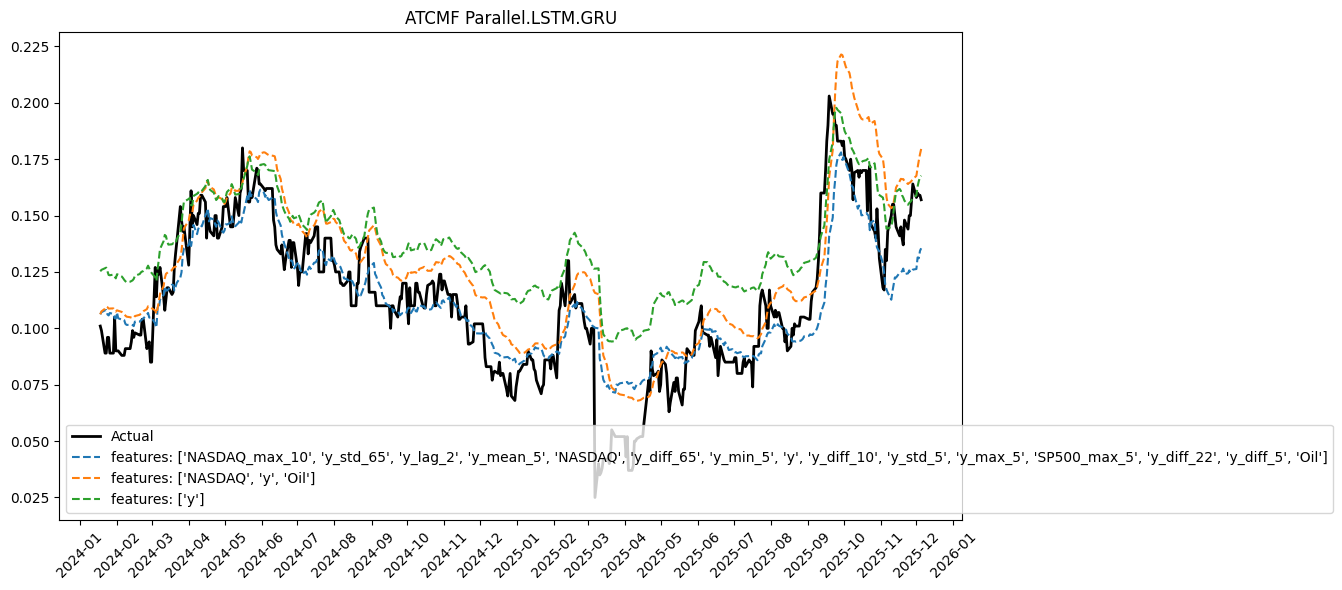

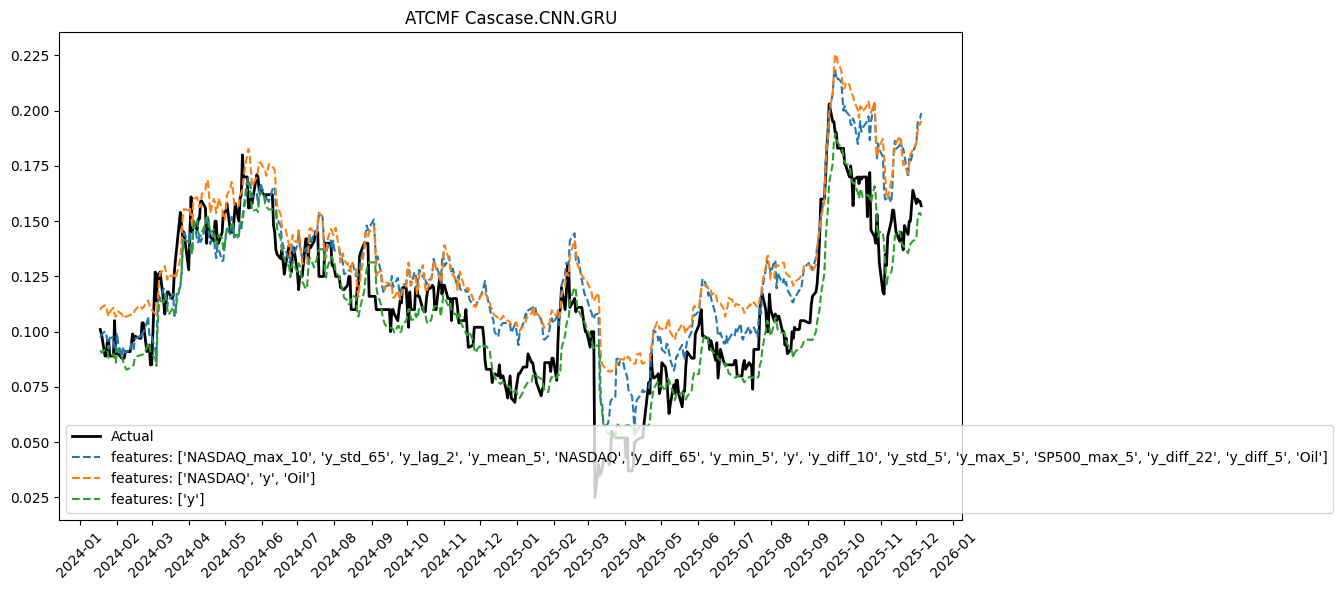

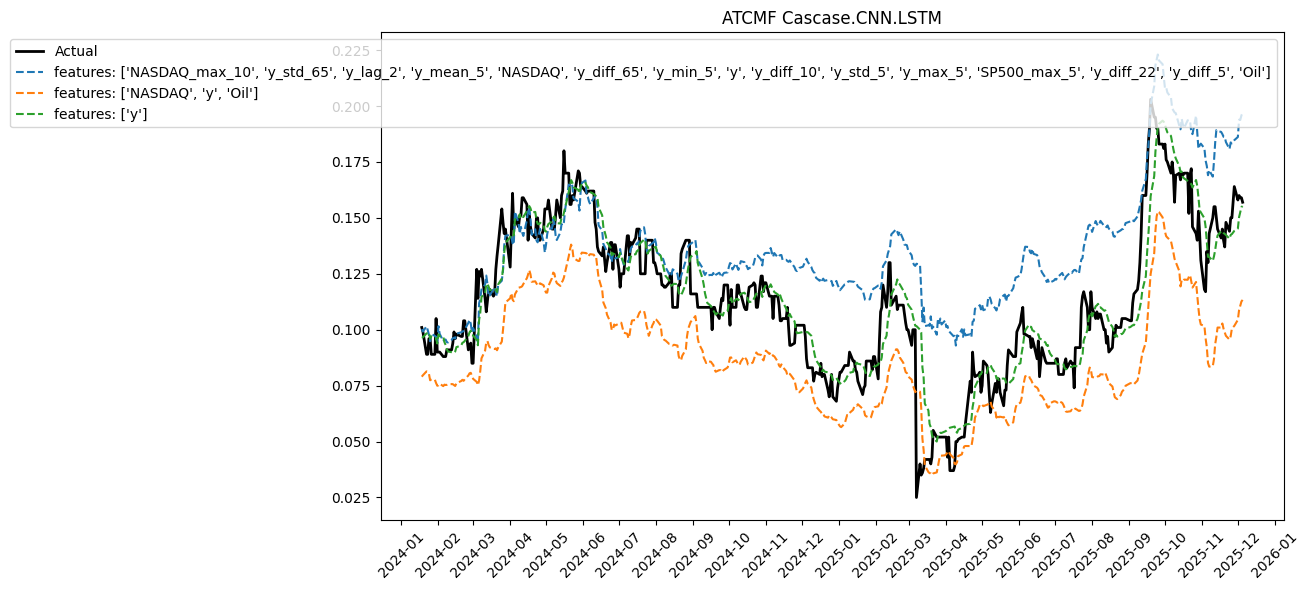

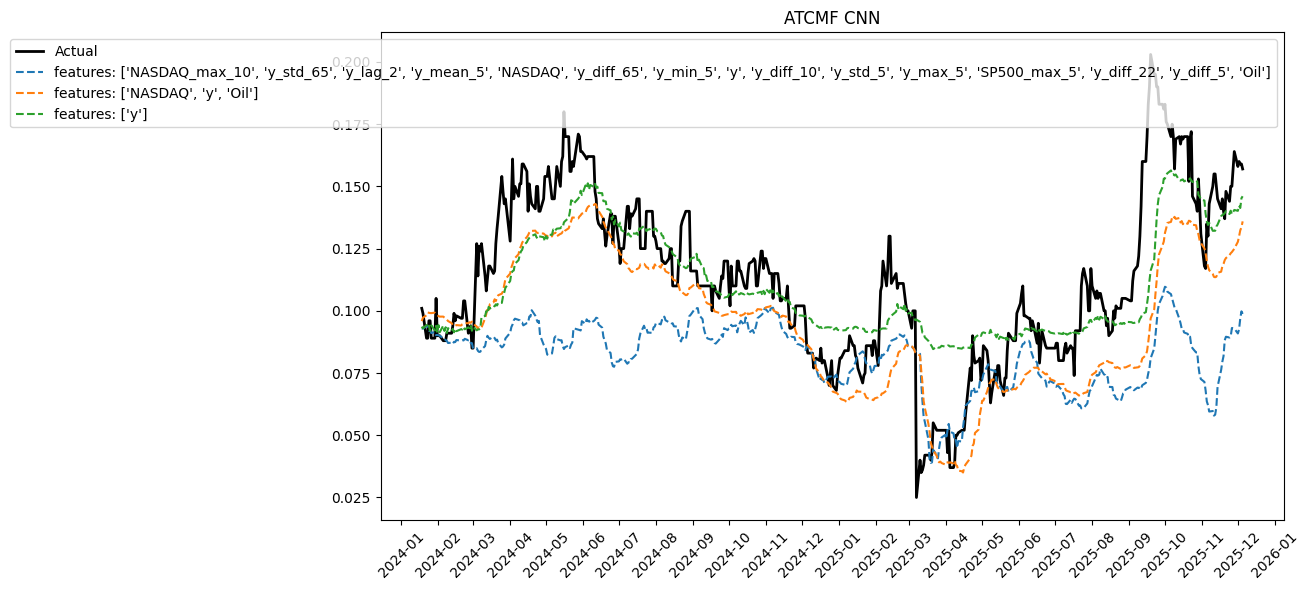

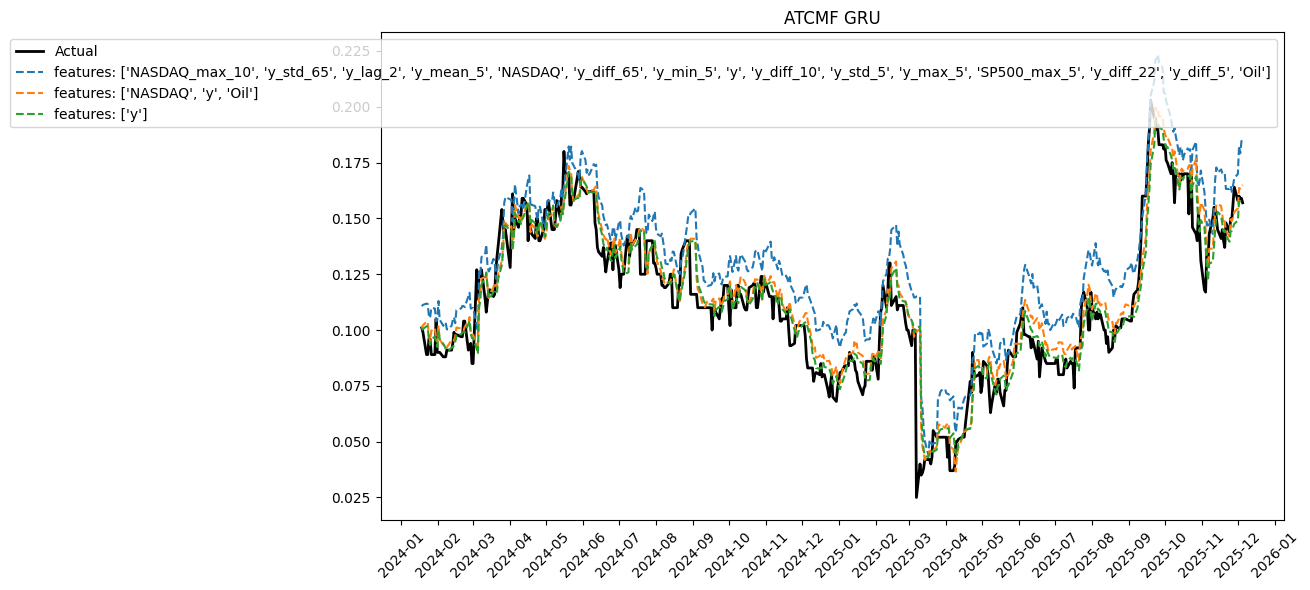

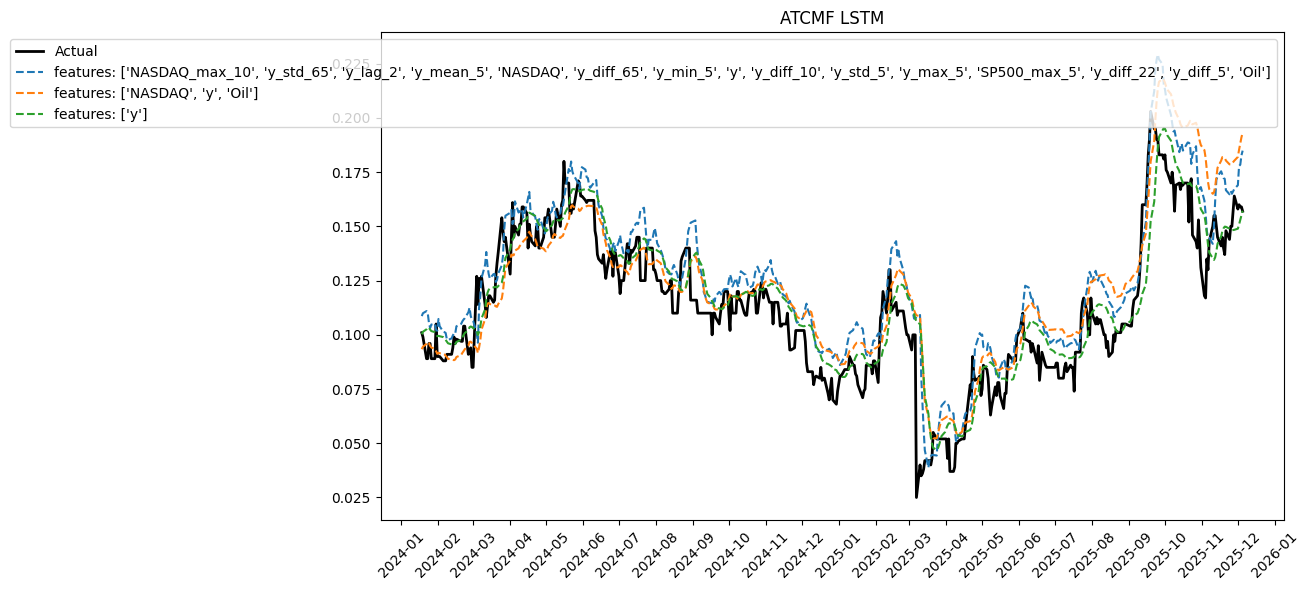

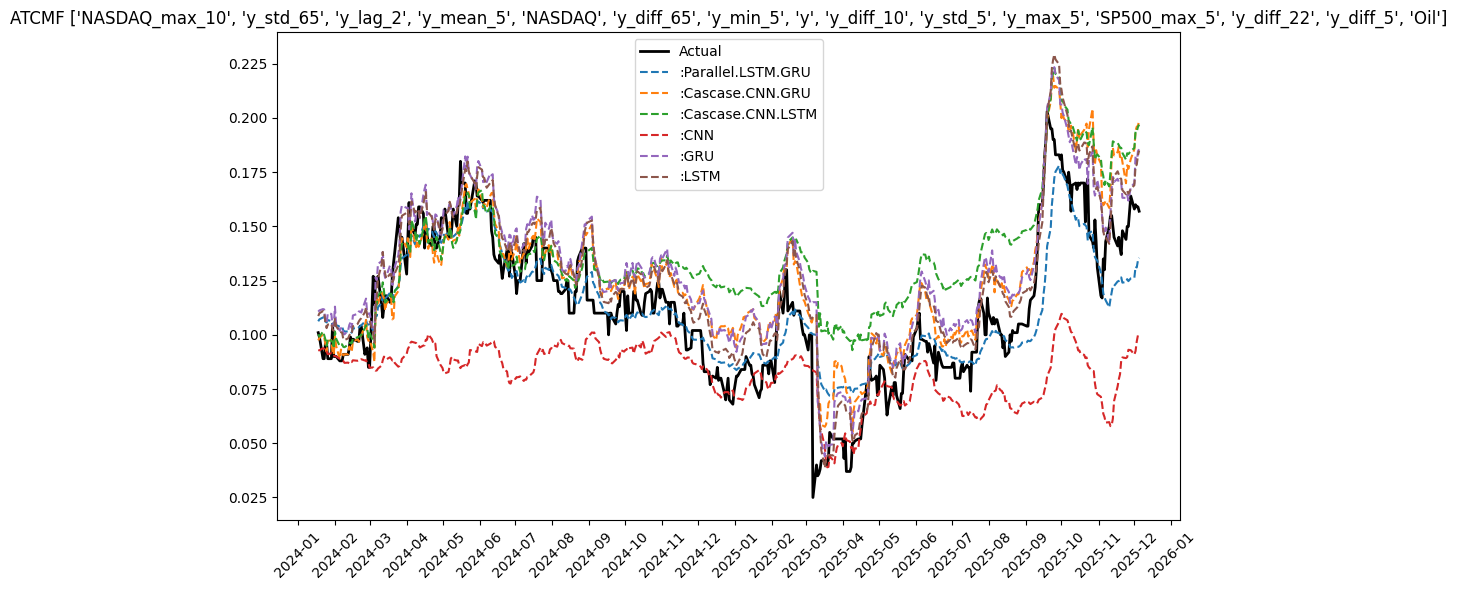

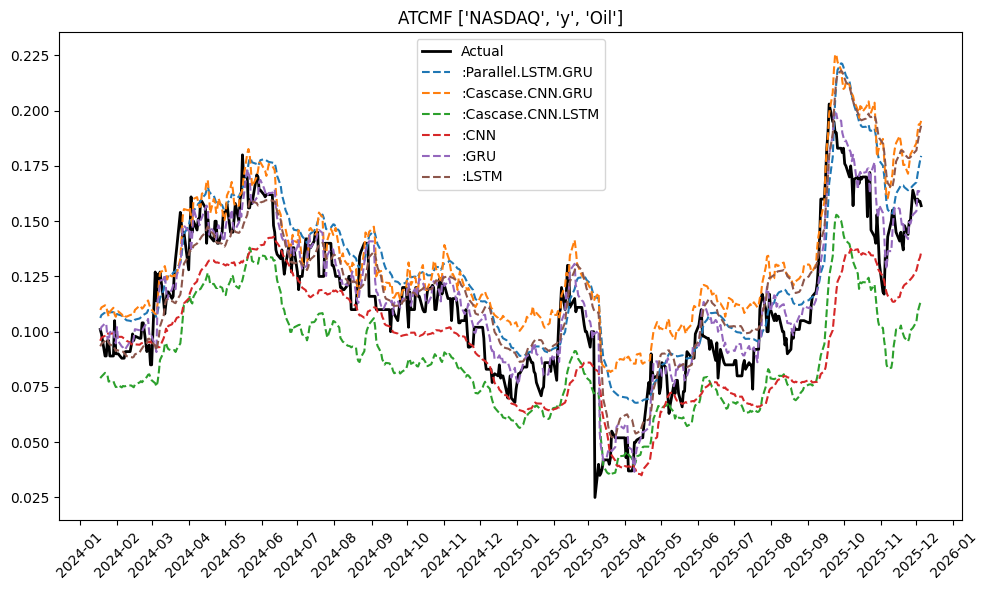

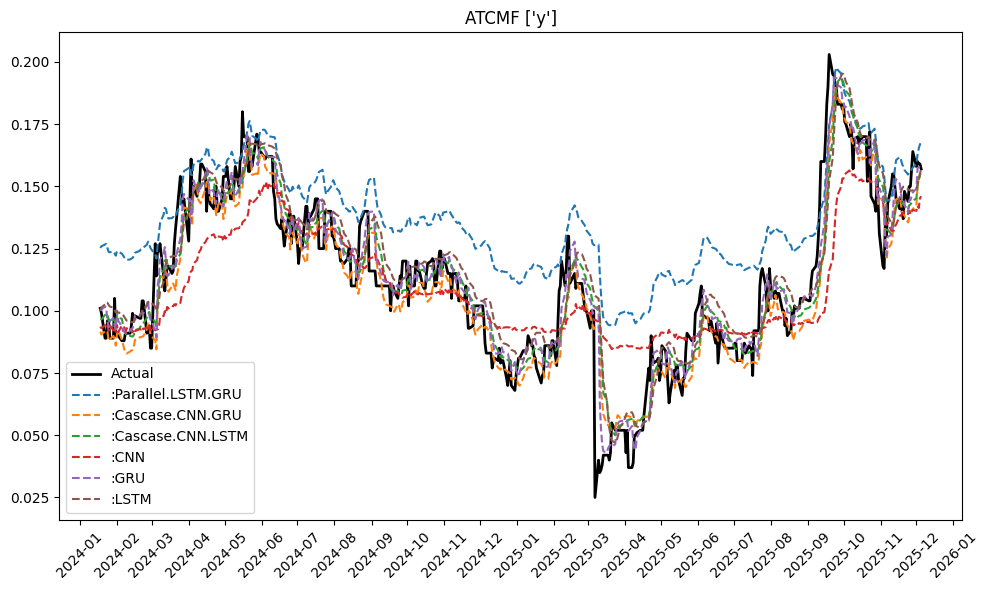

In [9]:
plot_results(results_df)

In [10]:
print(f"AND THE WINNER for {project_config['TKL']} IS ...")
display(results_df[['model_name', 'X_cols', 'mae', 'r2']].sort_values(by='mae', ascending=True))

AND THE WINNER for ATCMF IS ...


,model_name,X_cols,mae,r2
16,GRU,[y],0.007619,0.900117
10,GRU,"[NASDAQ, y, Oil]",0.008379,0.890551
13,Cascase.CNN.GRU,[y],0.009149,0.862969
14,Cascase.CNN.LSTM,[y],0.009153,0.857199
17,LSTM,[y],0.010661,0.816869
0,Parallel.LSTM.GRU,"[NASDAQ_max_10, y_std_65, y_lag_2, y_mean_5, N...",0.011570,0.775590
5,LSTM,"[NASDAQ_max_10, y_std_65, y_lag_2, y_mean_5, N...",0.014317,0.729104
11,LSTM,"[NASDAQ, y, Oil]",0.014584,0.683772
15,CNN,[y],0.014839,0.635539
1,Cascase.CNN.GRU,"[NASDAQ_max_10, y_std_65, y_lag_2, y_mean_5, N...",0.016167,0.651565


In [11]:
winning_model = results_df.sort_values(by='mae', ascending=True).iloc[0].model
winning_model_name = results_df.sort_values(by='mae', ascending=True).iloc[0].model_name
model_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.model.{winning_model_name}.keras"
winning_model.save(model_path)